In [1]:
import numpy as np
import matplotlib.pyplot as mp
from PIL import Image, ImageDraw, ImageFilter
import cv2 as cv
import scipy.signal as sig
import scipy.ndimage as img
import skimage.filters as filt
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
def Green(x, y):
    A = 0
    for i in range(1, len(x)):
        A += x[i-1]*y[i] - y[i-1]*x[i]
    return A/2

# Create images

In [4]:
N = 1000
r = 400

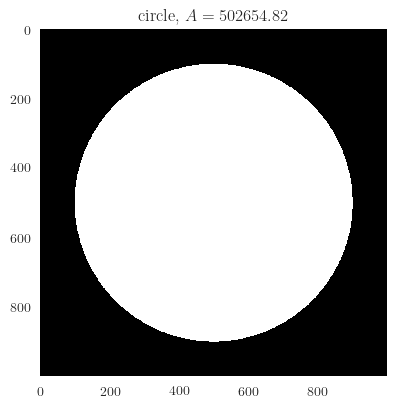

In [77]:
circspace = Image.new('L', (N, N), color='black')
circ = ImageDraw.Draw(circspace)
circ.ellipse((N//2-r, N//2-r, N//2+r, N//2+r), fill='white')
circspace.save('circle.png')
circ = np.array(circspace, 'uint8')
mp.imshow(circ, 'gray')
mp.title('circle, $A = {:.2f}$'.format(np.pi*r**2))
mp.grid(0)
mp.show()

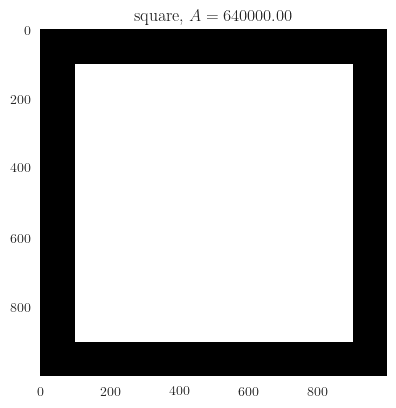

In [78]:
squarespace = Image.new('L', (N, N), color='black')
square = ImageDraw.Draw(squarespace)
square.rectangle((N//2-r, N//2-r, N//2+r, N//2+r), fill='white')
squarespace.save('square.png')
square = np.array(squarespace, 'uint8')
mp.imshow(square, 'gray')
mp.title('square, $A = {:.2f}$'.format((2*r)**2))
mp.grid(0)
mp.show()

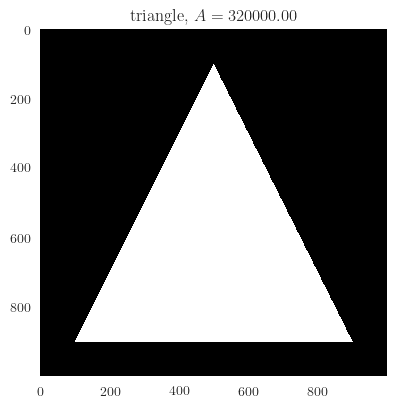

In [79]:
trispace = Image.new('L', (N, N), color='black')
tri = ImageDraw.Draw(trispace)
tri.polygon([(N//2, N//2-r), 
             (N//2-r), (N//2+r), 
             (N//2+r), (N//2+r)], fill='white')
trispace.save('triangle.png')
tri = np.array(trispace, 'uint8')
mp.imshow(tri, 'gray')
mp.title('triangle, $A = {:.2f}$'.format(2*r*2*r/2))
mp.grid(0)
mp.show()

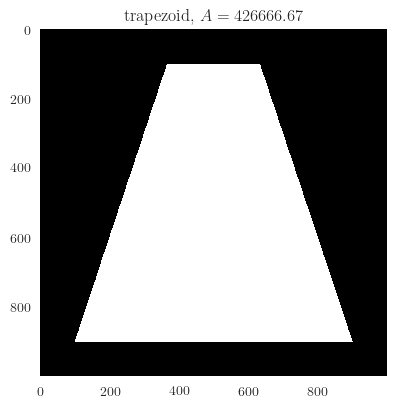

In [80]:
trapspace = Image.new('L', (N, N), color='black')
trap = ImageDraw.Draw(trapspace)
trap.polygon([(N//2-r, N//2+r), 
             (N//2+r), (N//2+r), 
             (N//2+r/3), (N//2-r),
             (N//2-r/3), (N//2-r)], fill='white')
trapspace.save('trapezoid.png')
trap = np.array(trapspace, 'uint8')
mp.imshow(trap, 'gray')
mp.title('trapezoid, $A = {:.2f}$'.format((2/3*r + 2*r)/2*2*r))
mp.grid(0)
mp.show()

# Import and find edges

In [8]:
methods = ['spot', 'sobel', 'prewitt', 'laplacian', 'canny']

In [5]:
def find_edge(filename, method):
    flag = None
    shape = Image.open(filename).convert('L')
    
    if method == 'spot':
        shape = shape.filter(ImageFilter.FIND_EDGES)
        flag = 'pil'
    elif method == 'sobel':
        shapex = img.sobel(shape, axis=0)
        shapey = img.sobel(shape, axis=1)
        shape = np.hypot(shapex, shapey)
        flag = 'numpy'
    elif method == 'prewitt':
        shapex = img.prewitt(shape, axis=0)
        shapey = img.prewitt(shape, axis=1)
        shape = np.hypot(shapex, shapey)
        flag = 'numpy'
    elif method == 'laplacian':
        shape = cv.imread(filename, 0)
        shape = cv.GaussianBlur(shape, (3,3), 0)
        shape = cv.Laplacian(shape, cv.CV_64F)
        flag = 'opencv'
    elif method == 'canny':
        shape = cv.imread(filename, 0)
        shape = cv.Canny(shape, 100, 200, 3, L2gradient=True)
        flag = 'opencv'
        
    newname = filename.split('.')[0] + '_' + method + '.png'
    
    if flag == 'pil':
        shape.save(newname)
    elif flag == 'numpy':
        shape = Image.fromarray(shape.astype('uint8'), 'L')
        shape.save(newname)
    elif flag == 'opencv':
        cv.imwrite(newname, shape)
        
    return shape

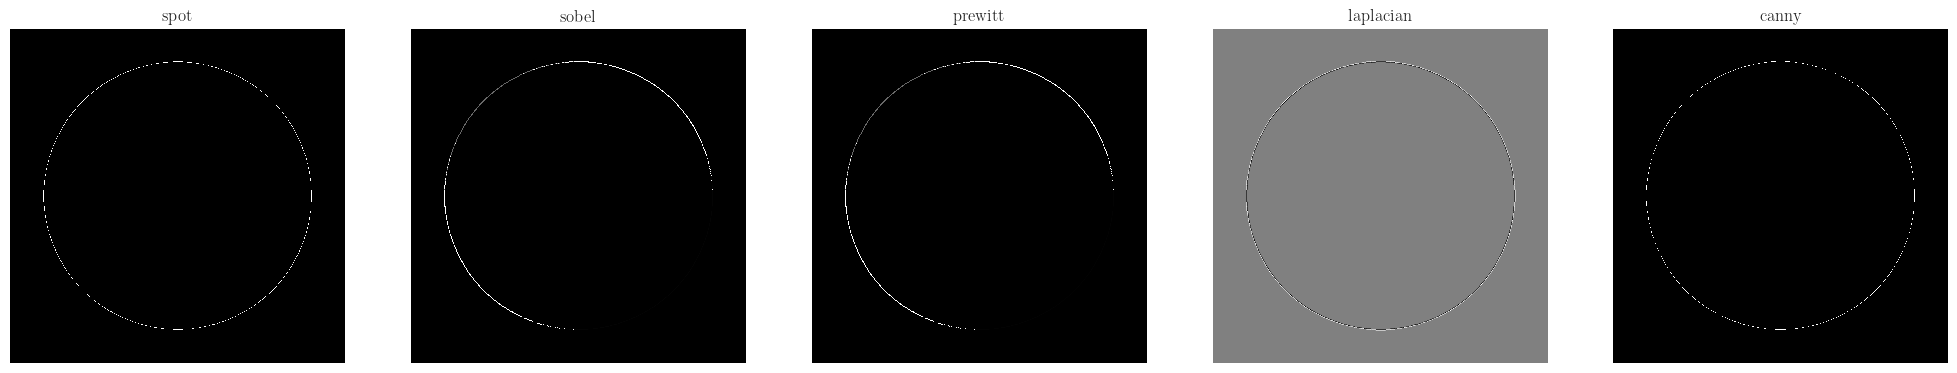

In [119]:
fig = mp.figure(figsize=(5*5, 5))
for i, m in enumerate(methods):
    ax = fig.add_subplot(1, 5, i+1)
    shape = find_edge('circle.png', m)
    ax.imshow(shape, 'gray')
    ax.axis('off')
    ax.grid(0)
    ax.set_title(m)
mp.show()

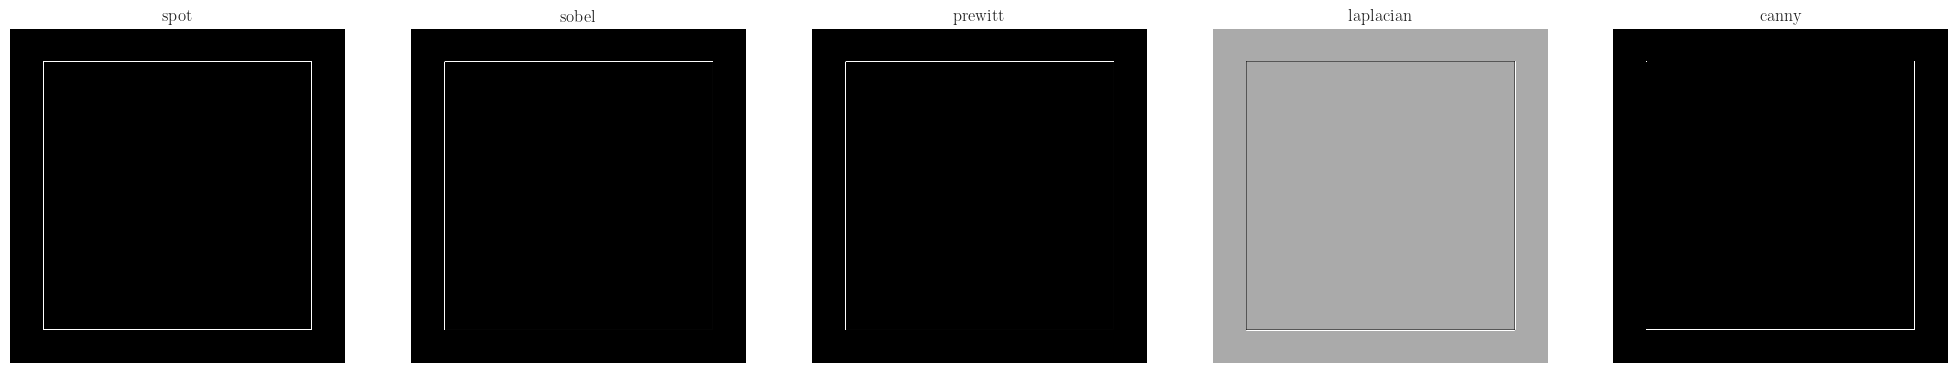

In [120]:
fig = mp.figure(figsize=(5*5, 5))
for i, m in enumerate(methods):
    ax = fig.add_subplot(1, 5, i+1)
    shape = find_edge('square.png', m)
    ax.imshow(shape, 'gray')
    ax.axis('off')
    ax.grid(0)
    ax.set_title(m)
mp.show()

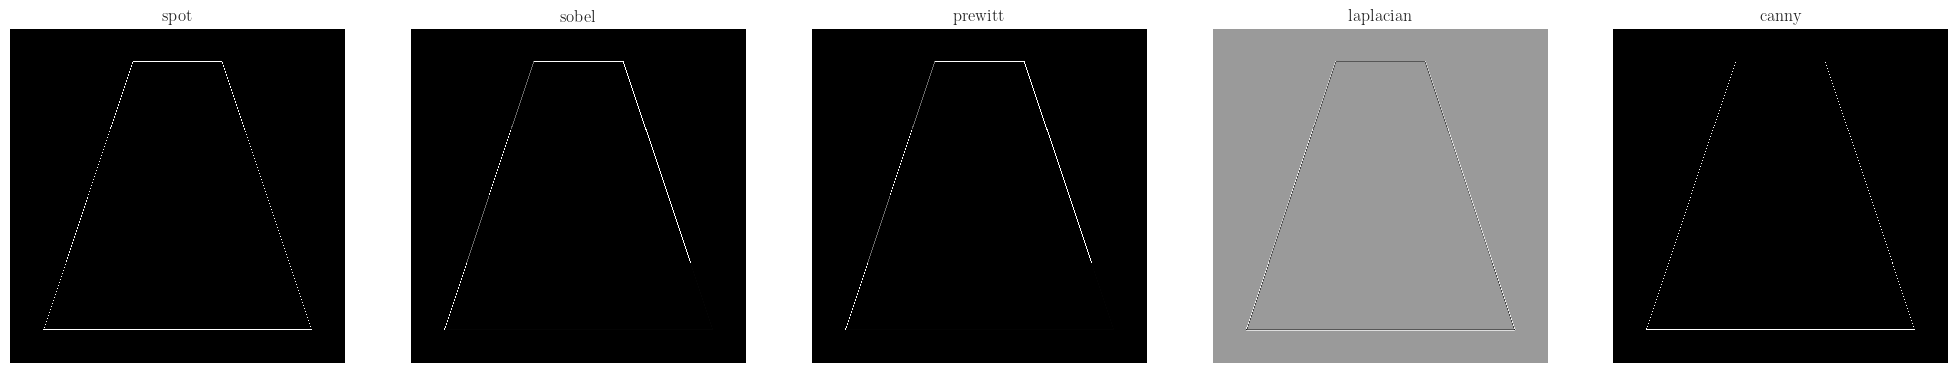

In [121]:
fig = mp.figure(figsize=(5*5, 5))
for i, m in enumerate(methods):
    ax = fig.add_subplot(1, 5, i+1)
    shape = find_edge('trapezoid.png', m)
    ax.imshow(shape, 'gray')
    ax.axis('off')
    ax.grid(0)
    ax.set_title(m)
mp.show()

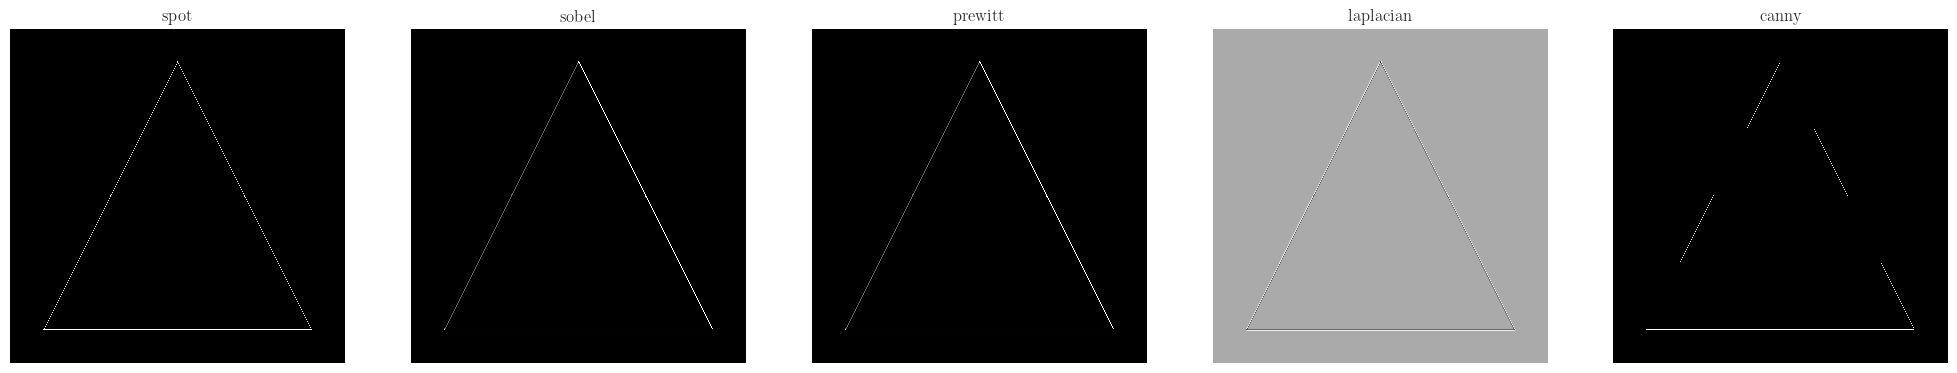

In [122]:
fig = mp.figure(figsize=(5*5, 5))
for i, m in enumerate(methods):
    ax = fig.add_subplot(1, 5, i+1)
    shape = find_edge('triangle.png', m)
    ax.imshow(shape, 'gray')
    ax.axis('off')
    ax.grid(0)
    ax.set_title(m)
mp.show()

# Calculate area using Green's Theorem

In [6]:
def GreenArea(shape, centroid):
    y, x = np.where(shape > 1)
    x -= centroid[0]
    y -= centroid[1]
    r = np.hypot(x, y)
    theta = np.arctan2(y, x)
    coor = np.array([x, y, r, theta]).T
    coor = coor[coor[:,3].argsort()]
    x, y, r, theta = coor.T
    A = Green(x, y)
    return A

In [9]:
print('CIRCLE')
A0 = 502655
for i, m in enumerate(methods):
    shape = find_edge('circle.png', m)
    shape = np.array(shape, 'uint8')
    A = GreenArea(shape, (N//2, N//2))
    print('{}: {} px \t {}% error'.format(m, A, abs(A-A0)/A0*100))

CIRCLE
spot: 501584.0 px 	 0.2130686057037133% error
sobel: 503187.0 px 	 0.10583800021883798% error
prewitt: 503187.0 px 	 0.10583800021883798% error
laplacian: 503198.0 px 	 0.10802637992261092% error
canny: 503181.5 px 	 0.10474381036695149% error


In [19]:
print('SQUARE')
A0 = 640000
for i, m in enumerate(methods):
    shape = find_edge('square.png', m)
    shape = np.array(shape, 'uint8')
    A = GreenArea(shape, (N//2, N//2))
    print('{}: {} px \t {}% error'.format(m, A, abs(A-A0)/A0*100))

SQUARE
spot: 639800.0 px 	 0.03125% error
sobel: 641403.5 px 	 0.219296875% error
prewitt: 641403.5 px 	 0.219296875% error
laplacian: 641415.5 px 	 0.22117187500000002% error
canny: 641397.5 px 	 0.21835937500000002% error


In [20]:
print('TRAPEZOID')
A0 = 426667
for i, m in enumerate(methods):
    shape = find_edge('trapezoid.png', m)
    shape = np.array(shape, 'uint8')
    A = GreenArea(shape, (N//2, N//2))
    print('{}: {} px \t {}% error'.format(m, A, abs(A-A0)/A0*100))

TRAPEZOID
spot: 426398.5 px 	 0.06292963833622005% error
sobel: 428002.0 px 	 0.3128903805543902% error
prewitt: 428002.0 px 	 0.3128903805543902% error
laplacian: 428013.0 px 	 0.3154685035402316% error
canny: 427730.5 px 	 0.24925761776748612% error


In [21]:
print('TRIANGLE')
A0 = 320000
for i, m in enumerate(methods):
    shape = find_edge('triangle.png', m)
    shape = np.array(shape, 'uint8')
    A = GreenArea(shape, (N//2, N//2))
    print('{}: {} px \t {}% error'.format(m, A, abs(A-A0)/A0*100))

TRIANGLE
spot: 319101.5 px 	 0.28078125% error
sobel: 320704.5 px 	 0.22015625% error
prewitt: 320705.0 px 	 0.22031249999999997% error
laplacian: 320714.0 px 	 0.22312500000000002% error
canny: 320303.5 px 	 0.09484374999999999% error


In [27]:
r_px = 389
r_m = 37.62
A0 = 4485.92
print('CS AMPHI')
for i, m in enumerate(methods):
    shape = find_edge('csamphi.png', m)
    shape = np.array(shape, 'uint8')
    A = GreenArea(shape, (1096, 560))
    r = A/r_px/np.pi
    r = px2len(r)
    A = np.pi*r*r
    print('{}: r = {} \t {} sq m \t {}% error'.format(m, A/r_px/np.pi, A, abs(A-A0)/A0*100))

CS AMPHI
spot: r = 3.764432804758922 	 4600.436318857226 sq m 	 2.552794496050442% error
sobel: r = 3.7890493740582 	 4630.519724598165 sq m 	 3.223412914143927% error
prewitt: r = 3.789072804580706 	 4630.548358560384 sq m 	 3.2240512216085926% error
laplacian: r = 3.7883308732102843 	 4629.641659410841 sq m 	 3.2038391101678427% error
canny: r = 3.7926350863801894 	 4634.9017502712495 sq m 	 3.321096904787634% error


In [16]:
px2len = lambda x: x/389 * 37.62